## Attention is all you need 실습
- 본 코드는 기본적으로 Attention is all you need (NIPS 2017) 논문의 내용을 최대한 따릅니다.
- 다만 일부 코드의 경우 Attention is all you need 내용을 따르지 않고 최신 아키텍처를 반영한 부분도 존재합니다. (가령, Positional Embedding 부분)

#### <b>데이터 전처리 (PreProcessing)</b>

**실행 커맨드**

```sh
conda install -n playground pytorch
conda install -n huggingface
```

- 허깅페이스 API를 이용해서 대표적인 영어-독어 데이터셋인 **Multi30k**를 불러옵니다.

In [4]:
from datasets import load_dataset

# Hugging Face에서 데이터셋 로드
dataset = load_dataset("bentrevett/multi30k")

/opt/anaconda3/envs/playground/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
train_dataset, validation_dataset, test_dataset = dataset['train'], dataset['validation'], dataset['test']

print(train_dataset[0])

{'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}


- **Tokenizer** 및 **Vocab** 생성

In [7]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [8]:
# Word-level tokenizer 초기화
unknown_token = "<unk>"

# 영어 토크나이저 정의 (Word Level)
en_tokenizer = Tokenizer(WordLevel(unk_token=unknown_token))
en_tokenizer.pre_tokenizer = Whitespace()

# 독일어 토크나이저 정의 (Word Level)
de_tokenizer = Tokenizer(WordLevel(unk_token=unknown_token))
de_tokenizer.pre_tokenizer = Whitespace()

In [9]:
# 학습용 trainer 설정 (vocab 생성)
pad_token, sos_token, eos_token = "<pad>", "<sos>", "<eos>"
special_tokens = [unknown_token, pad_token, sos_token, eos_token]

trainer = WordLevelTrainer(special_tokens=special_tokens, min_frequency=2)

In [10]:
# tokenizer 학습 (문장 리스트 기반)
train_en = train_dataset['en']
train_de = train_dataset['de']

en_tokenizer.train_from_iterator(train_en, trainer=trainer)
de_tokenizer.train_from_iterator(train_de, trainer=trainer)

In [11]:
# vocab 확인

print("[EN] vocab size: {}".format(en_tokenizer.get_vocab_size()))
print("[DE] vocab size: {}".format(de_tokenizer.get_vocab_size()))

print("[EN] Sample EN vocab tokens: {}".format(list(en_tokenizer.get_vocab().keys())[:10]))
print("[DE] Sample DE vocab tokens: {}".format(list(de_tokenizer.get_vocab().keys())[:10]))

[EN] vocab size: 6203
[DE] vocab size: 8060
[EN] Sample EN vocab tokens: ['slacks', 'rollerblading', 'apparel', 'shovel', 'clearing', 'gallery', 'runs', 'down', 'wrapped', 'splashed']
[DE] Sample DE vocab tokens: ['Segeln', 'erzielen', 'Hütte', 'genommen', 'Pferch', 'kaufen', 'Dachdecker', 'Sweater', 'Polizeibeamter', 'jüngeren']


In [12]:
# 특수 토큰 인덱스 체크

# <unk> : 0
# <pad> : 1
# <sos> : 2
# <eos> : 3
for special_token in special_tokens:
    print("[EN] special_token: {}, index: {}".format(special_token, en_tokenizer.get_vocab()[special_token]))
    print("[DE] special token: {}, index: {}".format(special_token, de_tokenizer.get_vocab()[special_token]))

[EN] special_token: <unk>, index: 0
[DE] special token: <unk>, index: 0
[EN] special_token: <pad>, index: 1
[DE] special token: <pad>, index: 1
[EN] special_token: <sos>, index: 2
[DE] special token: <sos>, index: 2
[EN] special_token: <eos>, index: 3
[DE] special token: <eos>, index: 3


- 하이퍼 파라미터 정의

In [44]:
class ModelConfiguration:
    def __init__(self, 
                 max_len: int = 768, 
                 batch_size: int = 32, 
                 hidden_size: int = 512, 
                 ffn_size: int = 2048,
                 num_heads: int = 8, 
                 num_layers: int = 6, 
                 dropout_pb: float = 0.1, 
                 src_vocab_size: int = 0, 
                 trg_vocab_size: int = 0
                ):
        self.max_len = max_len
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.ffn_size = ffn_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_pb = dropout_pb
        self.src_vocab_size = src_vocab_size
        self.trg_vocab_size = trg_vocab_size

model_config = ModelConfiguration(src_vocab_size=de_tokenizer.get_vocab_size(), trg_vocab_size=en_tokenizer.get_vocab_size())

- 데이터 전처리
  - 데이터 패딩 등..

In [46]:
# 각 언어 사전에서 특수 토큰 (sos, eos) id
en_sos_id, en_eos_id = en_tokenizer.token_to_id(sos_token), en_tokenizer.token_to_id(eos_token)
de_sos_id, de_eos_id = de_tokenizer.token_to_id(sos_token), de_tokenizer.token_to_id(eos_token)
de_pad_id, en_pad_id = de_tokenizer.token_to_id(pad_token), en_tokenizer.token_to_id(pad_token)

In [48]:
# input: {"en" : "example_en", "de" : "example_de"}
def preprocess(dataset: dict) -> dict:
    max_len = model_config.max_len
    batch_size = model_config.batch_size
    
    # 토큰 id로 변환
    src_input_ids = de_tokenizer.encode(dataset['de']).to
    trg_input_ids = en_tokenizer.encode(dataset['en']).ids

    # decoder 출력 부분에 special tokens 추가
    # I am a student 라는 문장이 있다면, 출력은 <sos> -> I, I -> am, ... 순으로 예측을 하기 때문
    decoder_input = [en_sos_id] + trg_input_ids
    labels = trg_input_ids + [en_eos_id]

    # padding
    encoder_input = src_input_ids[:max_len] + [de_pad_id] * max(0, max_len - len(src_input_ids))
    decoder_input = decoder_input[:max_len] + [en_pad_id] * max(0, max_len - len(decoder_input))
    labels = labels[:max_len] + [en_pad_id] * max(0, max_len - len(labels))

    # Attention mask (1 if real token else 0)
    encoder_attention_mask = [1 if token != de_pad_id else 0 for token in encoder_input]
    decoder_attention_mask = [1 if token != en_pad_id else 0 for token in decoder_input]

    return {
        "encoder_input_ids" : encoder_input,
        "encoder_attention_mask" : encoder_attention_mask,
        "decoder_input_ids" : decoder_input,
        "decoder_attention_mask" : decoder_attention_mask,
        "labels" : labels
    }

In [55]:
# 전처리 적용
train_dataset = train_dataset.map(preprocess, remove_columns=['en', 'de'])
validation_dataset = validation_dataset.map(preprocess, remove_columns=['en', 'de'])
test_dataset = test_dataset.map(preprocess, remove_columns=['en', 'de'])

Map: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 4155.15 examples/s]


In [56]:
# 전처리된 데이터셋 검증
print(train_dataset[10])

{'encoder_input_ids': [14, 5654, 10, 810, 28, 8, 19, 4270, 276, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [59]:
import torch

# collate function
def collate_function(batch):
    return {
        key: torch.tensor([data[key] for data in batch], dtype=torch.long) for key in batch[0]
    }

In [61]:
from torch.utils.data import DataLoader

# DataLoader 생성
batch_size = model_config.batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_function)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)

In [63]:
# 배치 샘플 확인
batch = next(iter(train_loader))

for key, value in batch.items():
    print("{}: shape={}".format(key, value.shape))

encoder_input_ids: shape=torch.Size([32, 768])
encoder_attention_mask: shape=torch.Size([32, 768])
decoder_input_ids: shape=torch.Size([32, 768])
decoder_attention_mask: shape=torch.Size([32, 768])
labels: shape=torch.Size([32, 768])


#### <b>토큰 임베딩</b>
- Attention is all you need 에서 소개된 토큰 임베딩은 크게 token 자체 임베딩, 위치 임베딩 둘을 합쳐서 구현합니다.
  - output = token_embedding(input_ids) + positional_embedding(input_ids)
  - positional embedding의 경우, Transformer 이전의 Seq2Seq 아키텍처 까지는 Residual block 들이 위치를 보장해주는 역할을 수행하였으나, Transformer 아키텍처 부터는 위치를 보장해주는 장치가 없어지다보니, 위치를 보장해주는 임베딩을 처리해야함.

In [69]:
# 학습 device 정의
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [91]:
import torch.nn as nn

class Embeddings(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_len: int, dropout_pb: float):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, hidden_size)
        self.positional_embedding = nn.Embedding(max_len, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout_pb)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        # 입력 시퀀스에 대한 positional ids 생성
        sequence_len = input_ids.size(1)
        positional_ids = torch.arange(sequence_len, device=device).unsqueeze(0).expand_as(input_ids)

        # 임베딩
        token_embeddings = self.token_embedding(input_ids)
        positional_embeddings = self.positional_embedding(positional_ids)

        # Add/Norm + Dropout
        embeddings = token_embeddings + positional_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

In [123]:
# 임베딩 검증
embedding_layer = Embeddings(
    vocab_size = model_config.src_vocab_size,
    hidden_size= model_config.hidden_size,
    max_len = model_config.max_len,
    dropout_pb = model_config.dropout_pb
).to(device)

batch = next(iter(train_loader))
input_ids = batch['encoder_input_ids'].to(device)

embeddings = embedding_layer(input_ids)

# 결과 확인
print("Input shape: {}".format(input_ids.shape))
print("Embedding shape: {}".format(embeddings.shape))

Input shape: torch.Size([32, 768])
Embedding shape: torch.Size([32, 768, 512])


#### <b>Multi Head Attention 구현</b>

- Transformer 아키텍처의 핵심인 멀티 헤드 어텐션을 구현합니다.
  - scaled-dot-product attention 구현
  - attention head 구현
  - Attention Head를 조합하여 Multi Head Attention 구현

#### Attention 공식

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} \right)V
$$

#### Masked Attention 공식

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} + \text{mask} \right)V
$$

- **점곱 어텐션** 구현
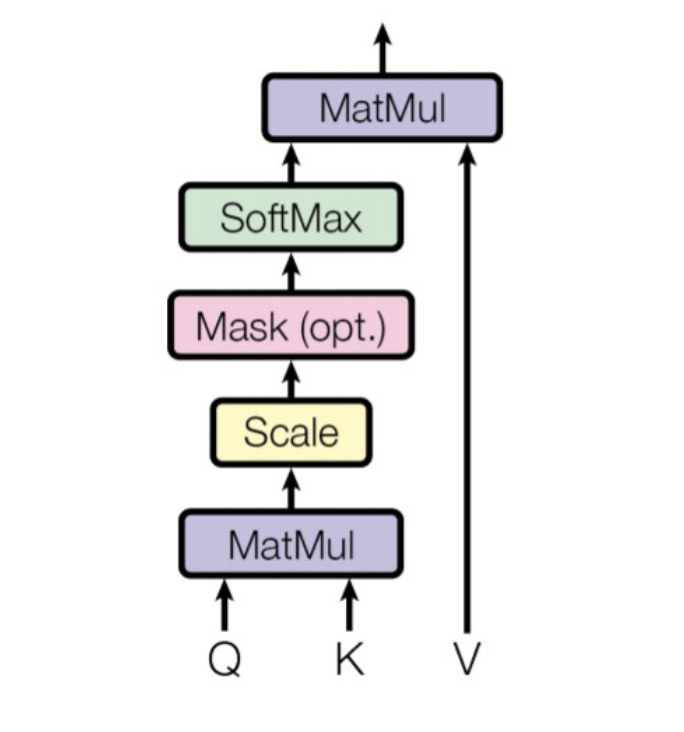

In [148]:
import torch.nn.functional as F

# Scaled dot product attention 구현
def scaled_dot_product_attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask = None) -> torch.Tensor:
    # hidden size
    dim_k = query.size(-1)

    # Attention score 계산
    scores = torch.bmm(query, key.transpose(1, 2)) / (dim_k ** 0.5)

    # mask가 존쟇라면 -1e9를 더한다
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # softmax로 attention wights
    attention_weights = F.softmax(scores, dim = -1)

    # attention * value
    output = torch.bmm(attention_weights, value)

    return output, attention_weights

- **Attention Head** 구현
  - 아래 그림 중에서, 헤드 부분을 구현합니다.
 
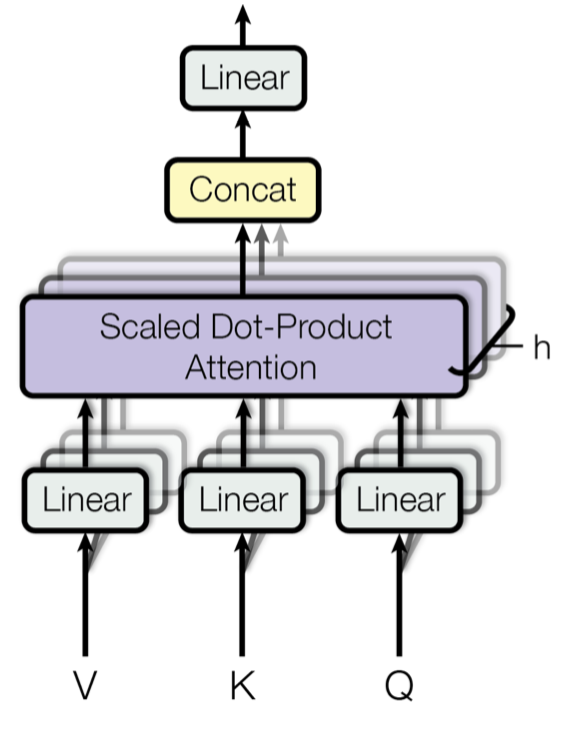

In [130]:
class AttentionHead(nn.Module):
    def __init__(self, hidden_dim: int, head_dim: int):
        super().__init__()
        self.query_projection = nn.Linear(hidden_dim, head_dim)
        self.key_projection = nn.Linear(hidden_dim, head_dim)
        self.value_projection = nn.Linear(hidden_dim, head_dim)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask = None):
        Q = self.query_projection(query)
        K = self.key_projection(key)
        V = self.value_projection(value)

        # mask까지 전달
        attention_output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)

        return attention_output

- **Multi Head Attention** 구현

In [139]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int):
        super().__init__()
        head_dim = hidden_dim // num_heads

        self.head_list = nn.ModuleList([AttentionHead(hidden_dim, head_dim) for _ in range(num_heads)])
        self.output_linear = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask = None) -> torch.Tensor:
        concat_attention = torch.concat([head(query, key, value, mask) for head in self.head_list], dim = -1)
        linear_output = self.output_linear(concat_attention)

        return linear_output

- 멀티 헤드 어텐션 테스트

In [150]:
multi_head_attention = MultiHeadAttention(hidden_dim = model_config.hidden_size, num_heads = model_config.num_heads).to(device)

# 이전 테스트에서 임베딩된 값을 입력으로 제공
attn_output = multi_head_attention(embeddings, embeddings, embeddings)

print(attn_output.size())

torch.Size([32, 768, 512])


#### <b>Positionwise Feed Forward 계층 설계</b>

- 트랜스포머 인코더와 디코더 계층 사이에 존재하는 완전 연결 신경망 계층

In [154]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_dim: int, ffn_dim: int, dropout_pb: float):
        super().__init__()
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_pb)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.dropout(x)

        return x

- 피드 포워드 테스트

In [157]:
feed_forward_layer = PositionwiseFeedForward(model_config.hidden_size, model_config.ffn_size, model_config.dropout_pb).to(device)

ff_outputs = feed_forward_layer(attn_output)

print(ff_outputs.size())

torch.Size([32, 768, 512])


#### <b>Transformer Encoder 설계</b>

- Encoder Stack 정의
- Encoder Stack을 여러개 쌓아서 Transformer Encoder 생성

**트랜스포머 도식**
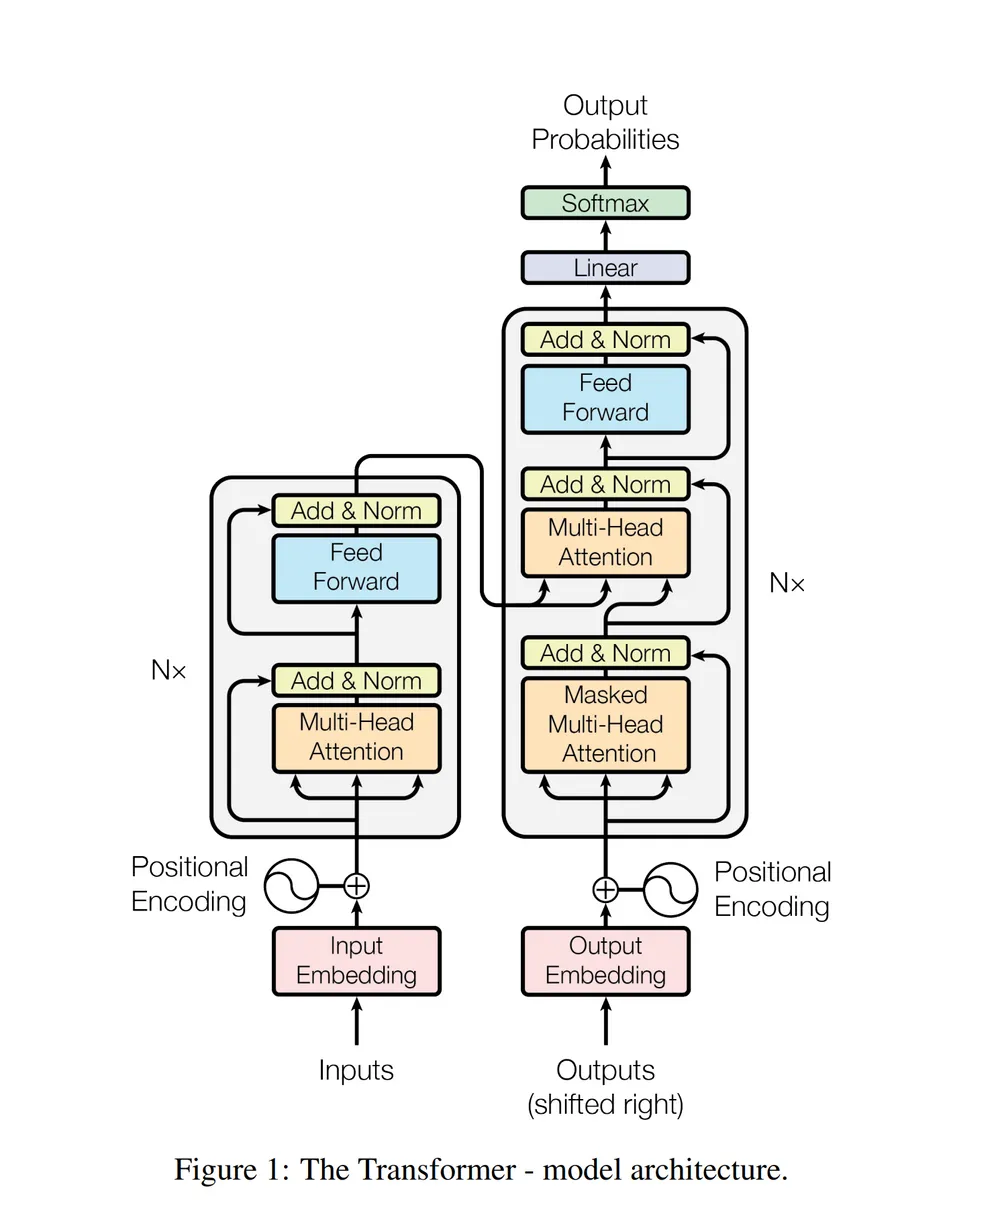

- **트랜스포머 인코더 스택** 정의
  - 본 논문에서는 사후 Normalization 기반으로 설명하고 있으나, 성능상으로는 **사전 Normalization** 이 더 우수하다고 알려져있기에, 본 코드에서는 사전 Normalization을 기반으로 구현합니다.

In [164]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim: int, ffn_dim: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.self_attention = MultiHeadAttention(hidden_dim, num_heads)
        self.feed_forward_layer = PositionwiseFeedForward(hidden_dim, ffn_dim, dropout_prob)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor, mask=None):
        # Pre Normalization
        x_norm1 = self.norm1(x)

        # Self Attention
        attention_output = self.self_attention(x_norm1, x_norm1, x_norm1, mask)

        # Dropout + Highway Adding
        x = x + self.dropout1(attention_output)

        # Pre Normalization
        x_norm2 = self.norm2(x)

        # Feed Forward
        ffn_output = self.feed_forward_layer(x_norm2)

        # Dropout + Highway Adding
        x = x + self.dropout2(ffn_output)

        return x

- **트랜스포머 인코더** 정의

In [167]:
class Encoder(nn.Module):
    def __init__(self, num_layers: int, hidden_dim: int, ffn_dim: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(hidden_dim, ffn_dim, num_heads, dropout_prob) for _ in range(num_layers)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.encoder_layers:
            x = layer(x)

        return x